<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Comics_Faces_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the connection to a GPU.

In [1]:
!nvidia-smi

Tue Sep  6 19:40:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the Kaggle package.

In [2]:
!pip install -q kaggle

Load the kaggle.json file in order to execute the download of the dataset. (Each user should upload his own file).

In [3]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import required libraries.

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras import layers
import numpy as np
from shutil import move
from os.path import join
import os
from google.colab import files
from shutil import copyfile

Download the dataset from a remote repository.

In [5]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

 99% 2.15G/2.18G [01:06<00:00, 30.1MB/s]
100% 2.18G/2.18G [01:06<00:00, 35.0MB/s]


Create Directories for Train, Validation and Test sets

In [6]:
os.makedirs(os.path.join(os.environ["data_source"], 'train/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'train/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/faces'))

tmp_comics_dir = './Face_Comics_data/comics'
tmp_faces_dir = './Face_Comics_data/faces'
comics_test_dir = './Face_Comics_data/test/comics'
faces_test_dir = './Face_Comics_data/test/faces'
comics_validation_dir = './Face_Comics_data/validation/comics'
faces_validation_dir = './Face_Comics_data/validation/faces'
comics_train_dir = './Face_Comics_data/train/comics'
faces_train_dir = './Face_Comics_data/train/faces'
train_dir = './Face_Comics_data/train'
validation_dir = './Face_Comics_data/validation'
test_dir = './Face_Comics_data/test'

Define global variables

In [7]:
TRAIN_TEST_SPLIT_AT = 0.7
TRAIN_VALIDATION_SPLIT_AT = 0.7
BATCH_SIZE = 64
EPOCHS = 45
EXPERIMENT_SIZE = 10000

Split the original dataset into Train, Validation and Test sets.

In [8]:
#TEST - TRAINING SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_train_dir, i))
      c += 1
    else:
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_test_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      try:
        move(os.path.join(tmp_faces_dir, i), os.path.join(faces_train_dir, i))
        c += 1
      except:
        c+= 1
        next
    else:
      move(os.path.join(tmp_faces_dir, i), os.path.join(faces_test_dir, i))
      c += 1

TRAIN_SIZE = len(os.listdir(comics_train_dir))

#TRAINING - VALIDATION SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/train/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/train/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(comics_train_dir, i), os.path.join(comics_validation_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(faces_train_dir, i), os.path.join(faces_validation_dir, i))
      c += 1

print('Total training images :', len(os.listdir(comics_train_dir)) + len(os.listdir(faces_train_dir)))
print('Total validation images :', len(os.listdir(comics_validation_dir)) + len(os.listdir(faces_validation_dir)))
print('Total test images :', len(os.listdir(comics_test_dir)) + len(os.listdir(faces_test_dir)))

Total training images : 9800
Total validation images : 4200
Total test images : 6000


Define data augmentation functions to be implemented in the analysis.

In [9]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

Define the CNN model, the Training and the Validation dataset. 

In [10]:
def get_compiled_model(i):
  if i == 1:
    ###Create CNN (NORMAL MODEL)
    ##Initialize the CNN
    model_1 = tf.keras.models.Sequential()
          
    model_1.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_1.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    model_1.add(tf.keras.layers.Flatten())
    #Full Connection
    model_1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_1.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])
    return model_1

  elif i == 2:
    ###Create CNN (DROPOUT MODEL)
    ##Initialize the CNN
    model_2 = tf.keras.models.Sequential()
        
    model_2.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_2.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    model_2.add(tf.keras.layers.Flatten())
        #Full Connection
    model_2.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #DROPOUTS ok(0.1)
    model_2.add(tf.keras.layers.Dropout(0.1))
    #Output Layer
    model_2.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_2

  elif i == 3:
    ###Create CNN (L1 REGULARIZATION MODEL)
    ##Initialize the CNN
    model_3 = tf.keras.models.Sequential()
        
    model_3.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_3.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_3.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    #Pooling
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_3.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    model_3.add(tf.keras.layers.Flatten())
    #Full Connection
    model_3.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_3.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
    ###Training CNN
    ##Compiling the CNN
    model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_3

  elif i == 4:
    ###Create CNN (L2 REGULARIZATION MODEL)
    ##Initialize the CNN
    model_4 = tf.keras.models.Sequential()
        
    model_4.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))
    
    #Convolution
    model_4.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    #Pooling
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    model_4.add(tf.keras.layers.Flatten())
    #Full Connection
    model_4.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_4.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_4

def get_dataset():
    BUFFER_SIZE = 10000
    IMG_SIZE = (350, 350)
    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


    tf.random.set_seed(123456)


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )

def AIC(n_examples, mse, n_model_parameters):
  AIC_SCORE = (n_examples * np.log(mse) ) + (2*n_model_parameters)
  return AIC_SCORE


Create a Mirrored strategy in order to distribute computation with Tensorflow engine.

In [14]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


Number of devices: 1


Example of data augmentation

Found 9800 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.
Found 6000 files belonging to 2 classes.


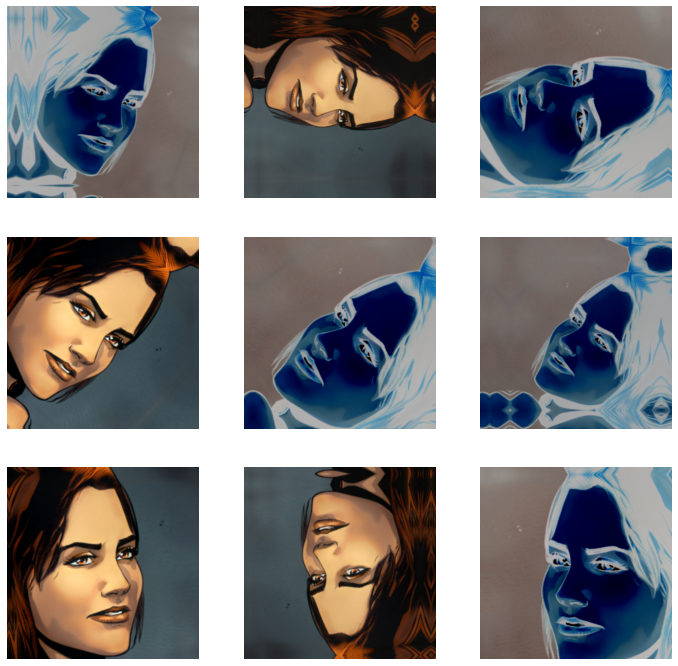

In [15]:
train_dataset, validation_dataset, test_dataset = get_dataset()

data_augmentation = tf.keras.Sequential([
	  layers.RandomFlip("horizontal_and_vertical"),
	  layers.RandomRotation(0.5),
    layers.RandomContrast(0.1, seed=None),
    RandomInvert(),
    layers.RandomZoom(height_factor=(-0.2, +0.3)),
    layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05))
    ])


for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Create a Strategy scope, and put the compiled model inside it. Run the distributed Training, Validation and Test analysis for each Model.

****************************** Model n.1 ******************************
Epoch 1/45
154/154 [==============================] - 87s 443ms/step - loss: 0.4486 - accuracy: 0.7732 - mse: 0.1482 - val_loss: 0.2002 - val_accuracy: 0.9224 - val_mse: 0.0582
Epoch 2/45
154/154 [==============================] - 71s 450ms/step - loss: 0.1746 - accuracy: 0.9348 - mse: 0.0485 - val_loss: 0.1094 - val_accuracy: 0.9621 - val_mse: 0.0305
Epoch 3/45
154/154 [==============================] - 70s 443ms/step - loss: 0.2725 - accuracy: 0.8996 - mse: 0.0760 - val_loss: 0.1744 - val_accuracy: 0.9302 - val_mse: 0.0501
Epoch 4/45
154/154 [==============================] - 70s 442ms/step - loss: 0.3381 - accuracy: 0.8621 - mse: 0.0976 - val_loss: 0.1532 - val_accuracy: 0.9448 - val_mse: 0.0415
Epoch 5/45
154/154 [==============================] - 70s 440ms/step - loss: 0.1746 - accuracy: 0.9347 - mse: 0.0484 - val_loss: 0.2562 - val_accuracy: 0.8986 - val_mse: 0.0755
Epoch 6/45
154/154 [=======================

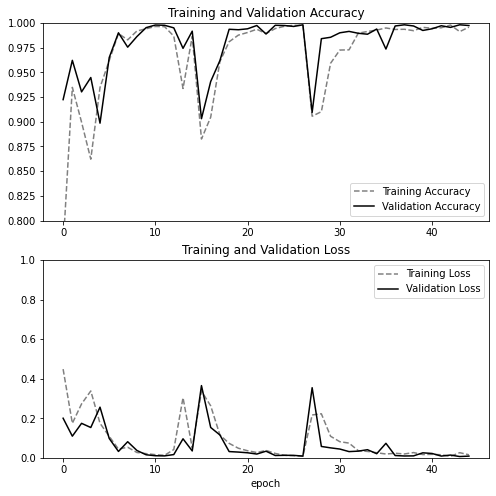

****************************** Test Evaluate ******************************
94/94 [==============================] - 32s 314ms/step - loss: 0.0128 - accuracy: 0.9968 - mse: 0.0029
****************************** Model n.2 ******************************
Epoch 1/45
154/154 [==============================] - 75s 447ms/step - loss: 0.4461 - accuracy: 0.7796 - mse: 0.1463 - val_loss: 0.3944 - val_accuracy: 0.8440 - val_mse: 0.1176
Epoch 2/45
154/154 [==============================] - 67s 424ms/step - loss: 0.2484 - accuracy: 0.9056 - mse: 0.0725 - val_loss: 0.0636 - val_accuracy: 0.9836 - val_mse: 0.0149
Epoch 3/45
154/154 [==============================] - 68s 430ms/step - loss: 0.1964 - accuracy: 0.9258 - mse: 0.0555 - val_loss: 0.1997 - val_accuracy: 0.9248 - val_mse: 0.0582
Epoch 4/45
154/154 [==============================] - 68s 430ms/step - loss: 0.1409 - accuracy: 0.9477 - mse: 0.0391 - val_loss: 0.1049 - val_accuracy: 0.9621 - val_mse: 0.0284
Epoch 5/45
154/154 [====================

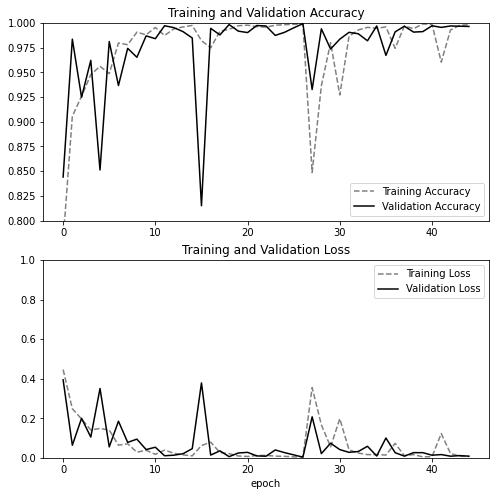

****************************** Test Evaluate ******************************
94/94 [==============================] - 28s 279ms/step - loss: 0.0122 - accuracy: 0.9963 - mse: 0.0027
****************************** Model n.3 ******************************
Epoch 1/45
(5, 5, 3, 32)
Tensor("Shape:0", shape=(4,), dtype=int32)
Tensor("Shape_1:0", shape=(4,), dtype=int32)
154/154 [==============================] - 75s 445ms/step - loss: 9.0551 - accuracy: 0.6741 - mse: 0.2364 - val_loss: 6.6008 - val_accuracy: 0.7588 - val_mse: 0.1894
Epoch 2/45
154/154 [==============================] - 70s 440ms/step - loss: 5.7824 - accuracy: 0.8123 - mse: 0.1749 - val_loss: 5.0631 - val_accuracy: 0.7869 - val_mse: 0.1739
Epoch 3/45
154/154 [==============================] - 68s 427ms/step - loss: 4.4630 - accuracy: 0.8528 - mse: 0.1526 - val_loss: 3.9168 - val_accuracy: 0.8824 - val_mse: 0.1394
Epoch 4/45
154/154 [==============================] - 70s 440ms/step - loss: 3.4914 - accuracy: 0.8713 - mse: 0.137

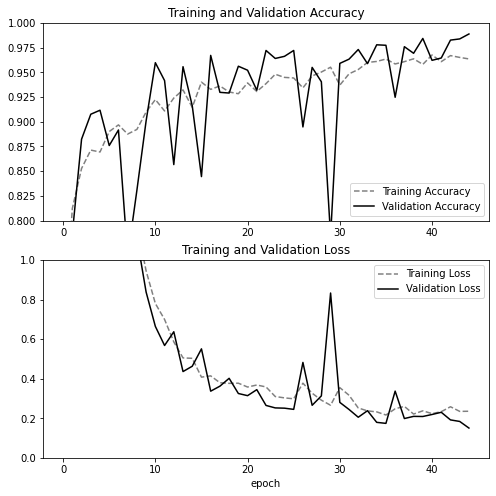

****************************** Test Evaluate ******************************
94/94 [==============================] - 30s 301ms/step - loss: 0.1490 - accuracy: 0.9878 - mse: 0.0092


****************************** Model n.4 ******************************
Epoch 1/45
154/154 [==============================] - 73s 433ms/step - loss: 2.5870 - accuracy: 0.7281 - mse: 0.1916 - val_loss: 0.9001 - val_accuracy: 0.8595 - val_mse: 0.1024
Epoch 2/45
154/154 [==============================] - 69s 434ms/step - loss: 0.8755 - accuracy: 0.8521 - mse: 0.1036 - val_loss: 0.7194 - val_accuracy: 0.9167 - val_mse: 0.0604
Epoch 3/45
154/154 [==============================] - 69s 435ms/step - loss: 0.7511 - accuracy: 0.8982 - mse: 0.0753 - val_loss: 0.6316 - val_accuracy: 0.9369 - val_mse: 0.0452
Epoch 4/45
154/154 [==============================] - 70s 441ms/step - loss: 0.6881 - accuracy: 0.9066 - mse: 0.0672 - val_loss: 0.6047 - val_accuracy: 0.9293 - val_mse: 0.0491
Epoch 5/45
154/154 [==============================] - 68s 426ms/step - loss: 0.6177 - accuracy: 0.9242 - mse: 0.0555 - val_loss: 0.5331 - val_accuracy: 0.9524 - val_mse: 0.0346
Epoch 6/45
154/154 [=======================

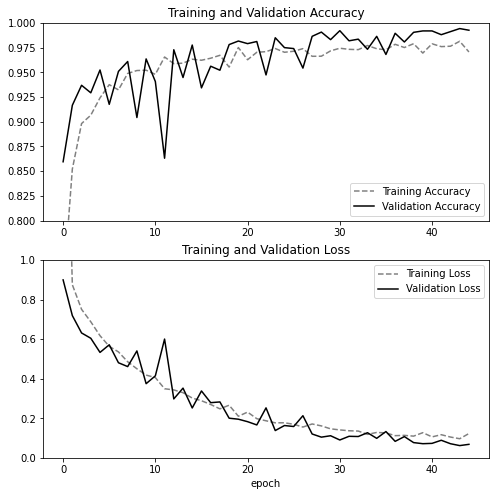

****************************** Test Evaluate ******************************
94/94 [==============================] - 28s 276ms/step - loss: 0.0660 - accuracy: 0.9927 - mse: 0.0056


In [16]:
#train_dataset, validation_dataset, test_dataset = get_dataset()

#Compute number of examples
Example_number = 9800

AIC_list = []
MSE_list = []
Models_parameters_n_list = []
for n in range(4):
  with strategy.scope():
    model = get_compiled_model(n+1)
    print(f'****************************** Model n.{n+1} ******************************')
    model_fit = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)
    model_fit
    model.summary()

    #Retrieve MSE values for each epoch
    Model_MSE = model_fit.history['mse']
    MSE_list += model_fit.history['mse']

    #Retrieve Parameters numbers for each model
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))

    substring = 'Trainable params'

    c = 0
    for n in stringlist:
        if substring not in n:
          c += 1
        else:
          break

    substring = stringlist[c]  
    Model_parameters_n = int("".join([i for i in substring if i.isdigit()]))
    Models_parameters_n_list += [Model_parameters_n]

    #Aikaike Information Creterion (AIC) Computation
    for mse_score in Model_MSE:
      AIC_SCORE = [AIC(Example_number, mse_score , Model_parameters_n)]
      AIC_list += AIC_SCORE

    #Show training and validation graphs
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    loss_ = model_fit.history['loss']
    val_loss_ = model_fit.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
    plt.plot(val_acc, label='Validation Accuracy', color = 'black')
    plt.ylim([0.8, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
    plt.plot(val_loss_, label='Validation Loss', color = 'black')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    print('****************************** Test Evaluate ******************************')
    model.evaluate(test_dataset)


Show Histoical validation AIC scores graphs

Text(0.5, 1.0, 'Validation AIC')

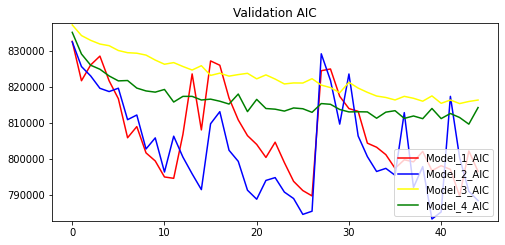

In [17]:
Model_1_AIC = AIC_list[0:EPOCHS]
Model_2_AIC = AIC_list[EPOCHS:EPOCHS*2]
Model_3_AIC = AIC_list[EPOCHS*2:EPOCHS*3]
Model_4_AIC = AIC_list[EPOCHS*3:EPOCHS*4]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Model_1_AIC, label='Model_1_AIC', color = 'red')
plt.plot(Model_2_AIC, label='Model_2_AIC', color = 'blue')
plt.plot(Model_3_AIC, label='Model_3_AIC', color = 'yellow')
plt.plot(Model_4_AIC, label='Model_4_AIC', color = 'green')
plt.ylim([min(AIC_list)-500, max(AIC_list)+500])
plt.legend(loc='lower right')
plt.title('Validation AIC')

Define Historical Average AIC scores graph

The Best Model is: Dropout (Model 2)


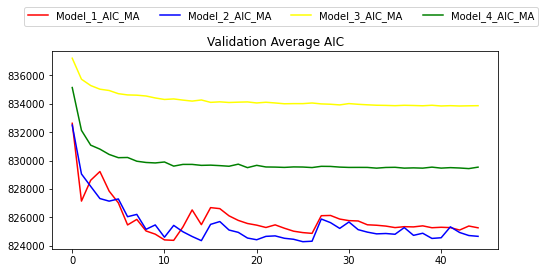

In [18]:
Model_1_AIC_MA = Model_1_AIC
Model_2_AIC_MA = Model_2_AIC
Model_3_AIC_MA = Model_3_AIC
Model_4_AIC_MA = Model_4_AIC

n = 0
for i in Model_1_AIC:
    avg_score_Model_1 = round(sum(Model_1_AIC[:(n+1)])/(n+1))
    avg_score_Model_2 = round(sum(Model_2_AIC[:(n+1)])/(n+1))
    avg_score_Model_3 = round(sum(Model_3_AIC[:(n+1)])/(n+1))
    avg_score_Model_4 = round(sum(Model_4_AIC[:(n+1)])/(n+1))
    Model_1_AIC_MA[n] = avg_score_Model_1
    Model_2_AIC_MA[n] = avg_score_Model_2
    Model_3_AIC_MA[n] = avg_score_Model_3
    Model_4_AIC_MA[n] = avg_score_Model_4
    n = n + 1

lim = Model_1_AIC_MA + Model_2_AIC_MA + Model_3_AIC_MA + Model_4_AIC_MA

Min = min(lim)
Max = max(lim)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Model_1_AIC_MA, label='Model_1_AIC_MA', color = 'red')
plt.plot(Model_2_AIC_MA, label='Model_2_AIC_MA', color = 'blue')
plt.plot(Model_3_AIC_MA, label='Model_3_AIC_MA', color = 'yellow')
plt.plot(Model_4_AIC_MA, label='Model_4_AIC_MA', color = 'green')
plt.ylim([(Min-500), (Max+500)])
plt.legend(bbox_to_anchor =(1.1, 1.25), ncol = 4)
plt.title('Validation Average AIC')

d = {
  "Normal (Model 1)": Model_1_AIC_MA[len(Model_1_AIC)-1],
  "Dropout (Model 2)": Model_2_AIC_MA[len(Model_2_AIC)-1],
  "L1 Regularization (Model 3)": Model_3_AIC_MA[len(Model_3_AIC)-1],
  "L2 Regularization (Model 4)": Model_4_AIC_MA[len(Model_4_AIC)-1]
}

best_model = min(d, key=d.get)
print(f'The Best Model is: {best_model}')

